In [1]:
import numpy as np
import sympy as sp
from sympy import ntheory
from sympy.ntheory import continued_fraction_reduce
from sympy import *
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power

In [2]:
def getOrtho(circ1,circ2):
    r1,x1 = circ1 
    r2,x2 = circ2
    c1 = x1**2-r1**2
    c2 = x2**2-r2**2
    x3 = (c1-c2)/(2*(h1-h2))
    r3 = np.sqrt(h**2+2*x1*h+c1)
    return (r3, x3)

In [3]:
def getDist(circ1,circ2):
    circ1,circ2 = getInv(circ1), getInv(circ2)
    t1,u1,v1 = circ1
    t2,u2,v2 = circ2
    return np.arccosh(t1*u2/2+t2*u1/2-v1*v2)

In [4]:
def normalToInv(circ):
    r,x = circ
    return ((x**2-r**2)/r, 1/r, x/r)

In [5]:
def InvToNormal(circ):
    t,u,v = circ
    r = 1/u
    x = r*v
    return (r,x)

In [6]:
def pairToFrac(s1, s2):
    return minPermutations(recover(list(s1) + [1] + list(inv(s2)) + [1]))

In [7]:
def pantsShear(pants1, pants2, y): # y is given in minimal form, without any 0's 
    
    s0,s1,s2 = pants1
    pants1Arr = []
    
    pants1Arr.append(pairToFrac(s1,s2))
    pants1Arr.append(pairToFrac(s2,s0))
    pants1Arr.append(pairToFrac(s0,s1))
    
    i = -1
    for l in range(3):
        if pants1Arr[l] == y:
            i = l
    
    pants1 = [pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)]
    pants1 = pants1[i:] + pants1[:i]
    
    s0,s1,s2 = pants2
    
    pants2Arr = []
    
    pants2Arr.append(pairToFrac(s1,s2))
    pants2Arr.append(pairToFrac(s2,s0))
    pants2Arr.append(pairToFrac(s0,s1))
    
    for l in range(3):
        if minPermutation(pants2Arr[l][::-1]) == y:
            i = l
    
    pants2 = [pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)]
    pants2 = pants2[i:] + pants2[:i]
    
    gamma_1 = pants1[0]
    gamma_2 = pants2[0]
    l = len(gamma_1)
    A_1 = np.eye(2)
    A_2 = np.eye(2)
    
    if gamma_1[0]==0:
        A_1 = np.linalg.inv(np.array([[0,1],[1,-gamma_1[1]]]) @ np.array([[0,1],[1,0]]))
        gamma_1[-1]+=gamma_1[0]
        gamma_1 = gamma_1[1:]
        
    
    if gamma_2[0]==0:
        A_2 = np.array([[0,1],[1,-gamma_2[1]]]) @ np.array([[0,1],[1,0]])
        gamma_2[-1]+=gamma_2[0]
        gamma_2 = gamma_2[1:]
        
    gamma_2 = gamma_2[::-1]
    
    k==-1
    for i in range(l/2):
        if (gamma_1[2*i:]+gamma_1[:2*i]) == gamma_2:
            k = 2*i

    mat = np.array([[0,1],[-1,0]])
    for i in range(k):
        mat = np.matmul(np.array([[0,1],[1,-gamma_1[i]]]), mat)
        
    B = np.array([[0,1],[-1,1]])
    T = np.array([[1,1],[0,1]])
    T_inv = np.array([[1,-1],[0,1]])
    
    M_1 = ((((((B @ T) @ A_1) @ mat)@ A_2) @ T_inv) @ matrix_power(B, 2))
    
    pants2_in_plane = pantsInPlane(pants2)
    min_max = [(x-r,x+r) for (r,x) in pants2_in_plane]
    pants2_in_plane = [(act(M_2, mini),act(M_2,maxi)) for (mini,maxi) in min_max]
    pants1_in_plane  = pantsInPlane(pants1)
    plotPants(pants1_in_plane)
    plotPants(pants2_in_plane)

In [8]:
def act(M,x):
    return (M[0,0]*x+M[0,1])/(M[1,0]*x+M[1,1])

In [9]:
def isOdd(sequence):
    return len(sequence) % 2

In [10]:
def permutationsOf(sequence):
    return list(permutationsOfGen(sequence))

In [11]:
def permutationsOfGen(sequence):
    for n in range(0, len(sequence), 1 if isOdd(sequence) else 2):
        yield rotl(sequence, n)

In [12]:
def minPermutation(sequence):
    return min(permutationsOfGen(sequence))

In [13]:
def inv(lr_sequence):
    return tuple((np.array(lr_sequence[::-1]) - 1) ** 2)

In [14]:
def pairToFrac2(s1,s2):
    return recover2(list(s1) + [1] + list(inv(s2)) + [1])

In [15]:
def recover(ls):
    output = []
    i = 0
    while i < len(ls):
        counter = 1
        while (i < len(ls) - 1 and ls[i] == ls[i + 1]):
            i += 1
            counter += 1
        i += 1
        output.append(counter)
    if isOdd(output):    #this is the line where we lump things
        output[-1] += output[0]
        output = output[1:]
    return output

def recover2(ls):
    output = []
    i = 0
    while i < len(ls):
        counter = 1
        while (i < len(ls) - 1 and ls[i] == ls[i + 1]):
            i += 1
            counter += 1
        i += 1
        output.append(counter)
    if isOdd(output):  
        output = [0]+output
    return output

In [16]:
#this cell for graphing matrices from continued fractions
def cfToMat(cf):
    mat = np.identity(2)
    length = 0
    for x in cf:
        mat = np.matmul(mat,[[x,1],[1,0]])
        length += 1
    if length % 2 == 1:
        mat = np.matmul(mat,mat)
    return np.array(mat).astype(int)

def geodesicInfoFromMatrix(M): #input is a hyperbolic matrix M which lies in SL_2(Z)
    tr = np.trace(M)
    if np.abs(tr) <= 2:
        raise ValueError('Matrix should have trace > 2')
    if tr < 0:
        M = -M
        tr = -tr
    length = 2*np.log(tr/2+np.sqrt((tr/2)**2-1))
    eig = np.exp(1)**(length/2)
    a = M.item(0,0)
    b = M.item(0,1)
    c = M.item(1,0)
    d = M.item(1,1)
    if c > 0:
        eigMat = (1/((c**2)*(tr**2-4))**(1/4))*np.matrix([[eig-d,1/eig-d],[c,c]])
    else: 
        eigMat = (1/((c**2)*(tr**2-4))**(1/4))*np.matrix([[-eig+d,1/eig-d],[-c,c]])
    visPt = (eig-d)/c
    newA = eigMat.item(0,0)
    newB = eigMat.item(0,1)
    newC = eigMat.item(1,0)
    newD = eigMat.item(1,1)
    visPtConj = (a - d - np.sqrt(tr**2 - 4))/(2*c)
    z = (newA*1j+newB)/(newC*1j+newD)
    zeta = 1j/(newC*1j+newD)**2
    return (length,eig,eigMat,visPt,visPtConj,z,zeta)

def plotMatrix(M): #input is a hyperbolic matrix M which lies in SL_2(Z)
    trace = np.trace(M)
    visPt = geodesicInfoFromMatrix(M)[3]
    visPtConj = geodesicInfoFromMatrix(M)[4]
    radius = (visPt - visPtConj)/2
    center = (visPt + visPtConj)/2
    circle = (radius, center)
    
    fig, ax = plt.subplots()
    minimum = -1 + (circle[1]-abs(circle[0]))
    maximum = 1 + (circle[1]+abs(circle[0]))
    ax.set_xlim(float(minimum),float(maximum))
    ax.set_ylim(0, float(abs(circle[0])+1))
    
    circle1 = plt.Circle((circle[1],0), abs(circle[0]), fill = False, color = 'r')
    
    if circle[0]>0:
        plt.plot(circle[1], abs(circle[0]), '>', color=  'r')
    else:
        plt.plot(circle[1], abs(circle[0]), '<', color=  'r')
    
    ax.add_artist(circle1)
    ax.set_aspect('equal', adjustable='box')

In [17]:
def pantsInPlane(pants): #y0 is on top, y2 on left, y1 in default position (reduced position +1)
    circles = []
    s0,s1,s2 = pants
    y2 = pairToFrac2(s0,s1)
    y0 = pairToFrac2(s1,s2)
    y1 = pairToFrac2(s2,s0)
    B = lambda x : 1/(1-x)
    
    alpha = ntheory.continued_fraction_reduce([y0])
    alpha_conj = -1/(ntheory.continued_fraction_reduce([y0[::-1]]))
    x_min = B(alpha_conj+1)
    x_max = B(alpha+1)
    r = (x_max-x_min)/2
    r = r.evalf()
    x = (x_min+x_max)/2
    x = x.evalf()
    circles.append((r,x))
    
    alpha = ntheory.continued_fraction_reduce([y1])
    alpha_conj = -1/(ntheory.continued_fraction_reduce([y1[::-1]]))
    x_min = (alpha_conj+1)
    x_max = (alpha+1)
    r = (x_max-x_min)/2
    r = r.evalf()
    x = (x_min+x_max)/2
    x = x.evalf()
    circles.append((r,x))
    
    alpha = ntheory.continued_fraction_reduce([y2])
    alpha_conj = -1/(ntheory.continued_fraction_reduce([y2[::-1]]))
    x_min = B(B(alpha_conj+1))
    x_max = B(B(alpha+1))
    r = (x_max-x_min)/2
    r = r.evalf()
    x = (x_min+x_max)/2
    x = x.evalf()
    circles.append((r,x))
    return circles

In [18]:
def plotPants(pants): # y0 is red, y1 is green, y2 is blue
    fig, ax = plt.subplots()
    
    circ1, circ2, circ3 = pantsInPlane(pants)
    minimum = -1+min(circ1[1]-abs(circ1[0]), circ2[1]-abs(circ2[0]), circ3[1]-abs(circ3[0]))
    maximum = 1+max(circ1[1]+abs(circ1[0]), circ2[1]+abs(circ2[0]), circ3[1]+abs(circ3[0]))
    ax.set_xlim(float(minimum),float(maximum))
    ax.set_ylim(0, float(max(abs(circ1[0]), abs(circ2[0]), abs(circ3[0]))+1))
    
    circle1 = plt.Circle((circ1[1],0), abs(circ1[0]), fill = False, color = 'r')
    circle2 = plt.Circle((circ2[1],0), abs(circ2[0]), fill = False, color = 'g')
    circle3 = plt.Circle((circ3[1],0), abs(circ3[0]), fill = False, color = 'b')
    
    if circ1[0]>0:
        plt.plot(circ1[1], abs(circ1[0]), '>', color=  'r')
    else:
        plt.plot(circ1[1], abs(circ1[0]), '<', color=  'r')
    if circ2[0]>0:
        plt.plot(circ2[1], abs(circ2[0]), '>', color=  'g')
    else:
        plt.plot(circ2[1], abs(circ2[0]), '<', color=  'g')
    if circ3[0]>0:
        plt.plot(circ3[1], abs(circ3[0]), '>', color=  'b')
    else:
        plt.plot(circ3[1], abs(circ3[0]), '<', color=  'b')
    
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(circle3)
    ax.set_aspect('equal', adjustable='box')
    s0,s1,s2 = pants
    print('red: ' + str(pairToFrac2(s0,s1)))
    print('green: ' + str(pairToFrac2(s1,s2)))
    print('blue: ' + str(pairToFrac2(s2,s0)))

In [19]:
def pantsInPlane2(pants):
    circles = []
    s0,s1,s2 = pants
    y2 = pairToFrac2(s0,s1)
    y0 = pairToFrac2(s1,s2)
    y1 = pairToFrac2(s2,s0)
    B = lambda x : 1/(1-x)
    
    alpha = ntheory.continued_fraction_reduce([y0])
    alpha_conj = -1/(ntheory.continued_fraction_reduce([y0[::-1]]))
    x_min = alpha_conj+1
    x_max = alpha+1
    r = (x_max-x_min)/2
    r = r.evalf()
    x = (x_min+x_max)/2
    x = x.evalf()
    circles.append((r,x))
    
    alpha = ntheory.continued_fraction_reduce([y1])
    alpha_conj = -1/(ntheory.continued_fraction_reduce([y1[::-1]]))
    x_min = alpha_conj+1
    x_max = alpha+1
    r = (x_max-x_min)/2
    r = r.evalf()
    x = (x_min+x_max)/2
    x = x.evalf()
    circles.append((r,x))
    
    alpha = ntheory.continued_fraction_reduce([y2])
    alpha_conj = -1/(ntheory.continued_fraction_reduce([y2[::-1]]))
    x_min = alpha_conj+1
    x_max = alpha+1
    r = (x_max-x_min)/2
    r = r.evalf()
    x = (x_min+x_max)/2
    x = x.evalf()
    circles.append((r,x))
    return circles
    
def plotPants2(pants):
    fig, ax = plt.subplots()
    
    circ1, circ2, circ3 = pantsInPlane2(pants)
    minimum = -1+min(circ1[1]-abs(circ1[0]), circ2[1]-abs(circ2[0]), circ3[1]-abs(circ3[0]))
    maximum = 1+max(circ1[1]+abs(circ1[0]), circ2[1]+abs(circ2[0]), circ3[1]+abs(circ3[0]))
    ax.set_xlim(float(minimum),float(maximum))
    ax.set_ylim(0, float(max(abs(circ1[0]), abs(circ2[0]), abs(circ3[0]))+1))
    
    circle1 = plt.Circle((circ1[1],0), abs(circ1[0]), fill = False, color = 'r')
    circle2 = plt.Circle((circ2[1],0), abs(circ2[0]), fill = False, color = 'g')
    circle3 = plt.Circle((circ3[1],0), abs(circ3[0]), fill = False, color = 'b')
    
    if circ1[0]>0:
        plt.plot(circ1[1], abs(circ1[0]), '>', color=  'r')
    else:
        plt.plot(circ1[1], abs(circ1[0]), '<', color=  'r')
    if circ2[0]>0:
        plt.plot(circ2[1], abs(circ2[0]), '>', color=  'g')
    else:
        plt.plot(circ2[1], abs(circ2[0]), '<', color=  'g')
    if circ3[0]>0:
        plt.plot(circ3[1], abs(circ3[0]), '>', color=  'b')
    else:
        plt.plot(circ3[1], abs(circ3[0]), '<', color=  'b')
        
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(circle3)
    ax.set_aspect('equal', adjustable='box')

red: [0, 13, 1, 1, 2, 1, 1, 2]
green: [1, 1, 1, 4, 1, 3]
blue: [2, 1, 1, 2, 13, 1]


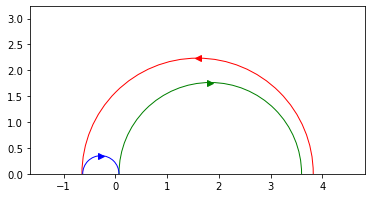

In [20]:
plotPants((10*[1]+ [1,1,1,0], [0,1,0,1,1], [0,0,1,0]))

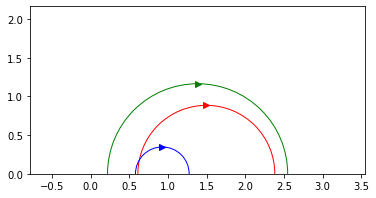

In [21]:
plotPants2(([0,1,1,0,1,0], [0,1,0,1,1],[1,1,1,0,1,0]))